In [2]:
# reload packages
%load_ext autoreload
%autoreload 2

### Choose GPU

In [3]:
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [4]:
import tensorflow as tf
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if len(gpu_devices)>0:
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
print(gpu_devices)
tf.keras.backend.clear_session()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
labels_per_class = 'full' # full

### Load packages

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
from IPython import display
import pandas as pd
import umap
import copy
import os, tempfile

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


### Load dataset

In [7]:
from tfumap.load_datasets import load_MNIST, mask_labels
X_train, X_test, X_valid, Y_train, Y_test, Y_valid = load_MNIST(flatten=False)
X_train.shape

(50000, 28, 28, 1)

In [8]:
if labels_per_class == "full":
    X_labeled = X_train
    Y_masked = Y_labeled = Y_train
else:
    X_labeled, Y_labeled, Y_masked = mask_labels(
        X_train, Y_train, labels_per_class=labels_per_class
    )

### Network architecture

In [9]:
dims = (28,28,1)
n_components= 2

In [10]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=128, kernel_size=3, strides=(2, 2), activation="relu"
    ),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=512, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])

### Test model with just UMAP

In [11]:
from tfumap.semisupervised import find_a_b
from tfumap.umap import convert_distance_to_probability

In [12]:
min_dist = 0.001
_a, _b = find_a_b(min_dist)
_a, _b 

(<tf.Tensor: shape=(), dtype=float32, numpy=1.9290735>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.79150456>)

##### build iterator

In [13]:
from tfumap.semisupervised import build_fuzzy_simplicial_set
from tfumap.umap import compute_cross_entropy, get_graph_elements

In [14]:
n_neighbors = 15  # default = 15
umap_graph = build_fuzzy_simplicial_set(
    X_train.reshape((len(X_train), np.product(np.shape(X_train)[1:]))),
    #y=Y_masked,
    n_neighbors=n_neighbors,
)

In [125]:
n_epochs = 200
graph, epochs_per_sample, head, tail, weight, n_vertices = get_graph_elements(
            umap_graph, n_epochs
)
batch_size = np.min([n_vertices, 60000])
batch_size

50000

In [126]:
max_sample_repeats_per_epoch = 25
# set the maximum number of times each edge should be repeated per epoch
epochs_per_sample = np.clip(
    (weight / np.max(weight)) * max_sample_repeats_per_epoch,
    1,
    max_sample_repeats_per_epoch,
).astype("int")

In [127]:
edges_to_exp, edges_from_exp = (
        np.repeat(head, epochs_per_sample.astype("int")),
       np.repeat(tail, epochs_per_sample.astype("int")),
)
shuffle_mask = np.random.permutation(range(len(edges_to_exp)))
edges_to_exp = edges_to_exp[shuffle_mask]
edges_from_exp = edges_from_exp[shuffle_mask]

In [128]:
negative_sample_rate = 5

In [129]:
def make_gen_callable(n_edges, batch_size):
    def edge_generator():
        while True:
            yield tf.random.uniform(
                (batch_size, 1), minval=0, maxval=n_edges, dtype=tf.int32
            ), tf.zeros(1, dtype=tf.int32)

    return edge_generator

In [130]:
n_edges = len(edges_to_exp)
n_edges

7709264

In [131]:
gen = make_gen_callable(n_edges, batch_size)

In [132]:
edge_iter = tf.data.Dataset.from_generator(gen, (tf.float32, tf.int32))


#### Build network

In [297]:
def umap_loss(batch_size, negative_sample_rate, _a, _b, repulsion_strength = 1.0):
    @tf.function
    def loss(placeholder_y, embed_to_from):
        # split out to/from
        embedding_to, embedding_from = tf.split(embed_to_from, num_or_size_splits=2, axis=1)

        # get negative samples
        embedding_neg_to = tf.repeat(embedding_to, negative_sample_rate, axis=0)
        repeat_neg = tf.repeat(embedding_from, negative_sample_rate, axis=0)
        embedding_neg_from = tf.gather(
            repeat_neg, tf.random.shuffle(tf.range(tf.shape(repeat_neg)[0]))
        )

        #  distances between samples (and negative samples)
        distance_embedding = tf.concat(
            [
                tf.norm(embedding_to - embedding_from, axis=1),
                tf.norm(embedding_neg_to - embedding_neg_from, axis=1),
            ],
            axis=0,
        )

        # convert probabilities to distances
        probabilities_distance = convert_distance_to_probability(
            distance_embedding, _a, _b
        )
        
        # set true probabilities based on negative sampling
        probabilities_graph = tf.concat(
            [tf.ones(batch_size), tf.zeros(batch_size * negative_sample_rate)],
            axis=0,
        )
                
        # compute cross entropy
        if True:
            (attraction_loss, repellant_loss, ce_loss) = compute_cross_entropy(
                probabilities_graph,
                probabilities_distance,
                repulsion_strength=repulsion_strength,
            )
        else:
            ce_loss = tf.keras.losses.binary_crossentropy(probabilities_graph, probabilities_distance)
        #return tf.reduce_mean(ce_loss)
        return ce_loss

    return loss

### initialize embedding

In [134]:
from umap.spectral import spectral_layout

from sklearn.utils import check_random_state

random_state = check_random_state(None)
metric = "euclidean"
_metric_kwds = {}
def init_embedding_from_graph(_raw_data, graph, n_components, random_state, metric, _metric_kwds, init="spectral"):
        """ Initialize embedding using graph. This is for direct embeddings. 

        Parameters
        ----------
        init : str, optional
            Type of initialization to use. Either random, or spectral, by default "spectral"

        Returns
        -------
        embedding : np.array
            the initialized embedding
        """
        if isinstance(init, str) and init == "random":
            embedding = random_state.uniform(
                low=-10.0, high=10.0, size=(graph.shape[0], n_components)
            ).astype(np.float32)
        elif isinstance(init, str) and init == "spectral":
            # We add a little noise to avoid local minima for optimization to come

            initialisation = spectral_layout(
                _raw_data,
                graph,
                n_components,
                random_state,
                metric=metric,
                metric_kwds=_metric_kwds,
            )
            expansion = 10.0 / np.abs(initialisation).max()
            embedding = (initialisation * expansion).astype(
                np.float32
            ) + random_state.normal(
                scale=0.0001, size=[graph.shape[0], n_components]
            ).astype(
                np.float32
            )

        else:
            init_data = np.array(init)
            if len(init_data.shape) == 2:
                if np.unique(init_data, axis=0).shape[0] < init_data.shape[0]:
                    tree = KDTree(init_data)
                    dist, ind = tree.query(init_data, k=2)
                    nndist = np.mean(dist[:, 1])
                    embedding = init_data + random_state.normal(
                        scale=0.001 * nndist, size=init_data.shape
                    ).astype(np.float32)
                else:
                    embedding = init_data

        return embedding

In [135]:
embedding = init_embedding_from_graph(X_train, graph, n_components, random_state, metric, _metric_kwds, init="spectral")

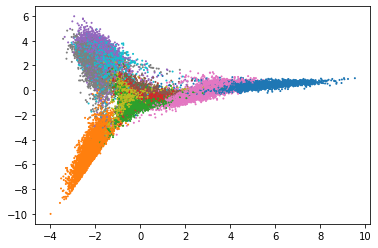

In [136]:
plt.scatter(embedding[:,0], embedding[:,1], c=Y_train, s=1, cmap=plt.cm.tab10)

In [216]:
from tensorflow.keras.layers import Input

In [298]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [299]:
to_ = tf.constant(edges_to_exp)
from_ = tf.constant(edges_from_exp)

In [300]:
batch_sample = Input(shape=(1), dtype=tf.float32, name = "to_x")

to_x = tf.gather(to_, tf.cast(batch_sample, tf.int32))
from_x = tf.gather(from_, tf.cast(batch_sample, tf.int32))

embedding_to = encoder(to_x)[:,-1,:]
embedding_from = encoder(from_x)[:,-1,:]

embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)

model = tf.keras.Model(
    inputs=[batch_sample],
    outputs=[embedding_to_from],#[embedding_to_from],
)

In [301]:
embedding_to_from

<tf.Tensor 'umap/umap_19/Identity:0' shape=(None, 4) dtype=float32>

In [302]:
model.compile(
    optimizer=tf.keras.optimizers.Adadelta(50),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b),
    #run_eagerly=True
)

#### train

In [303]:
history = model.fit(
    edge_iter,
    epochs=5,
    max_queue_size = 5,
    #use_multiprocessing=True, 
    #workers = -1,
)

Epoch 1/5
     85/Unknown - 4s 47ms/step - loss: 0.2750

KeyboardInterrupt: 

In [172]:
z = encoder.weights[0].numpy()

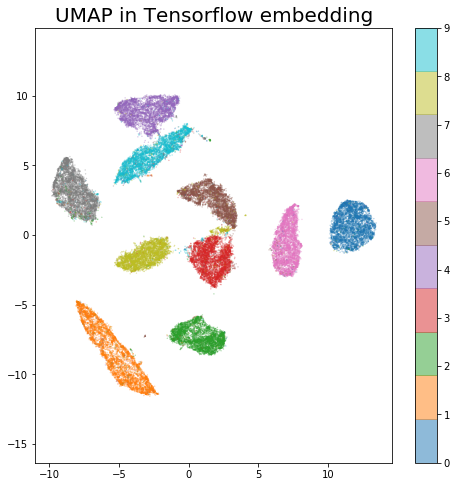

In [173]:
fig, ax = plt.subplots( figsize=(8, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=Y_train.astype(int)[:len(z)],
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP in Tensorflow embedding", fontsize=20)
plt.colorbar(sc, ax=ax);

In [304]:
loss_fn = umap_loss(batch_size, negative_sample_rate, _a, _b)

training_variables = encoder.trainable_variables
alpha = tf.Variable(1.0)
opt = tf.keras.optimizers.Adadelta(50)

In [ ]:
batch_n = 0
for batch_sample, y_ in tqdm(edge_iter):
    with tf.GradientTape() as tape:

        to_x = tf.gather(to_, tf.cast(batch_sample, tf.int32))
        from_x = tf.gather(from_, tf.cast(batch_sample, tf.int32))

        embedding_to = encoder(to_x)[:,-1,:]
        embedding_from = encoder(from_x)[:,-1,:]

        embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
        embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)
        loss = loss_fn(y_, embedding_to_from)
        loss2 = model.compiled_loss(y_, embedding_to_from)
        grads = tape.gradient(loss, training_variables)
        grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
        opt.apply_gradients(zip(grads, training_variables))
        
    
    if batch_n % 500 == 0:
        print(batch_n, np.mean(loss.numpy()), np.mean(loss2.numpy()))
        
    batch_n += 1

0 0.273131 0.27290678


In [168]:
embedding_to.shape

TensorShape([50000, 2])

In [169]:
grads

[<tf.Tensor: shape=(50000, 2), dtype=float32, numpy=
 array([[ 1.2207029 ,  0.34495923],
        [-1.0126532 ,  0.31238455],
        [ 0.9369293 ,  0.5658897 ],
        ...,
        [ 0.        ,  0.        ],
        [ 0.2086939 , -1.1657425 ],
        [-0.3784781 ,  0.13090687]], dtype=float32)>]

In [122]:
np.sum(grads[0] > 0.0)

1925

In [121]:
np.sum(grads[0] == 0.0)

96098

(array([4.0000e+00, 1.5800e+02, 1.6100e+02, 1.0740e+03, 9.7675e+04,
        6.6500e+02, 1.3500e+02, 1.2600e+02, 0.0000e+00, 2.0000e+00]),
 array([-5.561873  , -4.281302  , -3.0007312 , -1.7201605 , -0.4395896 ,
         0.84098125,  2.121552  ,  3.402123  ,  4.682694  ,  5.9632645 ,
         7.2438354 ], dtype=float32),
 <a list of 10 Patch objects>)

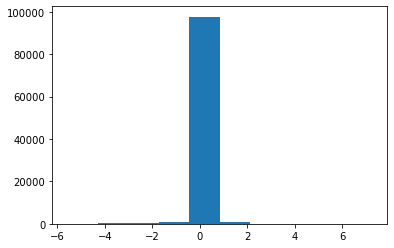

In [118]:
plt.hist(grads[0].numpy().flatten())

In [65]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=0.11049231>

In [35]:
plt.plot(history.history['loss'])

NameError: name 'history' is not defined

In [281]:
class CustomModel(tf.keras.Model):
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)
            loss = loss_fn(y, y_pred)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        print(gradients)
        gradients = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in gradients] 

        
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}

In [282]:
n_data = len(X_train)
embedding_layer = tf.keras.layers.Embedding(n_data, n_components, input_length=1)
embedding_layer.build(input_shape=(1,)) # the input_shape here has no effect in the build function
embedding_layer.set_weights([embedding])
encoder = tf.keras.Sequential([embedding_layer])

In [283]:
to_ = tf.constant(edges_to_exp)
from_ = tf.constant(edges_from_exp)

In [284]:
batch_sample = Input(shape=(1), dtype=tf.float32, name = "to_x")

to_x = tf.gather(to_, tf.cast(batch_sample, tf.int32))
from_x = tf.gather(from_, tf.cast(batch_sample, tf.int32))

embedding_to = encoder(to_x)[:,-1,:]
embedding_from = encoder(from_x)[:,-1,:]

embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)


In [285]:
model = CustomModel(
    inputs=[batch_sample],
    outputs=[embedding_to_from],#[embedding_to_from],
)

In [286]:

model.compile(
    optimizer=tf.keras.optimizers.Adadelta(50),
    loss=umap_loss(batch_size, negative_sample_rate, _a, _b)
)

In [287]:
if True:
    history = model.fit(
        edge_iter,
        epochs=5,
        max_queue_size = 100,
        #use_multiprocessing=True, 
        #workers = -1,
    )

Epoch 1/5
   9524/Unknown - 177s 19ms/step - loss: 0.1037

KeyboardInterrupt: 

In [265]:
loss_fn = umap_loss(batch_size, negative_sample_rate, _a, _b)

training_variables = encoder.trainable_variables
alpha = tf.Variable(1.0)
opt = tf.keras.optimizers.Adadelta(50)

In [266]:
batch_n = 0
for batch_sample, y_ in tqdm(edge_iter):
    with tf.GradientTape() as tape:

        to_x = tf.gather(to_, tf.cast(batch_sample, tf.int32))
        from_x = tf.gather(from_, tf.cast(batch_sample, tf.int32))

        embedding_to = encoder(to_x)[:,-1,:]
        embedding_from = encoder(from_x)[:,-1,:]

        embedding_to_from = tf.keras.layers.concatenate([embedding_to, embedding_from],axis=1)
        embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name='umap')(embedding_to_from)
        loss = loss_fn(y_, embedding_to_from)
        loss2 = model.compiled_loss(y_, embedding_to_from)
        #grads = tape.gradient(loss2, training_variables)
        grads = tape.gradient(loss, training_variables)
        grads = [tf.clip_by_value(grad, -4.0, 4.0) * alpha for grad in grads] # * alpha
        opt.apply_gradients(zip(grads, training_variables))
        break
    
    if batch_n % 500 == 0:
        print(batch_n, np.mean(loss.numpy()), np.mean(loss2.numpy()))
        
    batch_n += 1

In [267]:
loss2

<tf.Tensor: shape=(), dtype=float32, numpy=0.27081794>

In [256]:
loss

<tf.Tensor: shape=(300000,), dtype=float32, numpy=
array([0.9091207 , 0.07638296, 0.27512035, ..., 0.01909071, 0.04371547,
       0.00947431], dtype=float32)>

In [272]:
loss

<tf.Tensor: shape=(300000,), dtype=float32, numpy=
array([0.84868157, 0.10005572, 0.02769483, ..., 0.02587358, 0.08448728,
       0.10064588], dtype=float32)>

(array([1.67612e+05, 3.34820e+04, 1.90370e+04, 1.47310e+04, 1.12460e+04,
        8.60500e+03, 6.78700e+03, 5.80700e+03, 4.62500e+03, 3.99500e+03,
        3.38800e+03, 2.81200e+03, 2.45000e+03, 2.25300e+03, 1.83100e+03,
        1.65700e+03, 1.45500e+03, 1.19300e+03, 1.00800e+03, 8.95000e+02,
        7.59000e+02, 6.50000e+02, 5.89000e+02, 4.76000e+02, 3.86000e+02,
        3.38000e+02, 3.01000e+02, 2.53000e+02, 2.01000e+02, 1.71000e+02,
        1.42000e+02, 1.11000e+02, 1.01000e+02, 9.00000e+01, 6.30000e+01,
        7.10000e+01, 4.40000e+01, 3.40000e+01, 4.10000e+01, 3.10000e+01,
        3.10000e+01, 2.10000e+01, 1.40000e+01, 2.30000e+01, 1.40000e+01,
        1.80000e+01, 1.40000e+01, 1.60000e+01, 1.50000e+01, 7.00000e+00,
        1.30000e+01, 1.10000e+01, 1.10000e+01, 1.10000e+01, 3.00000e+00,
        7.00000e+00, 3.00000e+00, 6.00000e+00, 2.00000e+00, 3.00000e+00,
        3.00000e+00, 4.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00,
        2.00000e+00, 2.00000e+00, 1.00000e+00, 2.00

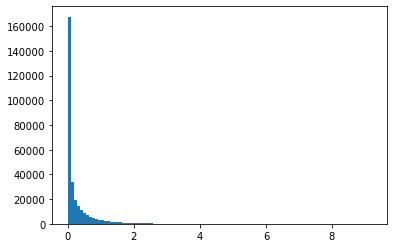

In [274]:
plt.hist(loss.numpy(), bins=100)

In [280]:
??model.compiled_loss